# Introduction to single-cell Variational Inference (scVI)
In this introductory tutorial, we go through the different steps of a scVI workflow

1. Loading the data
2. Training the model
3. Retrieving the latent space and imputed values
4. Visualize the latent space with scanpy
5. Perform differential expression 
6. Correcting batch effects with scVI
7. Miscenalleous information

In [1]:
# If running in Colab, navigate to Runtime -> Change runtime type
# and ensure you're using a Python 3 runtime with GPU hardware accelerator
# Installation of scVI in Colab can take several minutes

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/stable/tests/notebooks/basic_tutorial.ipynb)

In [2]:
import sys
IN_COLAB = "google.colab" in sys.modules

def allow_notebook_for_test():
    print("Testing the basic tutorial notebook")

show_plot = True
test_mode = False
save_path = "data/"

if not test_mode:
    save_path = "../../data"

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@dataset_refactor#egg=scvi[notebooks]

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scvi
import scanpy as sc

if IN_COLAB:
    %matplotlib inline

# Sets torch and numpy random seeds, run after all scvi imports
scvi.set_seed(0)

## Loading data

Let us first load the CORTEX dataset described in Zeisel et al. (2015). Loading data into scVI is easy, and works using the Scanpy/AnnData packages. scVI also has many "built-in" datasets. Please see our [data loading Jupyter notebook](https://nbviewer.jupyter.org/github/YosefLab/scVI/blob/master/tests/notebooks/data_loading.ipynb) for more examples of data loading.

* Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 

In [4]:
gene_dataset = scvi.dataset.cortex(save_path=save_path)

# We do a standard normalization for scanpy downstream visualization
# Putting the count data in a layer preserves them for scVI
sc.pp.filter_genes(gene_dataset, min_cells=15)
gene_dataset.layers["counts"] = gene_dataset.X.copy()
sc.pp.normalize_total(gene_dataset, target_sum=1e4)
sc.pp.log1p(gene_dataset)

scvi.dataset.highly_variable_genes_seurat_v3(gene_dataset, n_top_genes=2000, layer="counts", subset=True)

[2020-07-21 21:26:29,363] INFO - scvi.dataset._utils | File /data/expression.bin already downloaded
[2020-07-21 21:26:29,366] INFO - scvi.dataset.cortex | Loading Cortex data from /data/expression.bin
[2020-07-21 21:26:40,026] INFO - scvi.dataset.cortex | Finished loading Cortex data


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[2020-07-21 21:26:42,219] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-21 21:26:42,220] INFO - scvi.dataset._anndata | No batch_key inputted, assuming all cells are same batch
[2020-07-21 21:26:42,229] INFO - scvi.dataset._anndata | Using labels from adata.obs["labels"]
[2020-07-21 21:26:42,231] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-21 21:26:42,529] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 3005 cells, 19972 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
[2020-07-21 21:26:45,791] INFO - scvi.dataset._preprocessing | added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [5]:
# Representation of the dataset object
print(gene_dataset)


AnnData object with n_obs × n_vars = 3005 × 2000
    obs: 'labels', 'precise_labels', 'cell_type', '_scvi_batch', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scvi_data_registry', 'scvi_summary_stats', 'log1p', 'hvg'
    layers: 'counts'


In [6]:
scvi.dataset.setup_anndata(gene_dataset, layer="counts")

[2020-07-21 21:26:46,126] INFO - scvi.dataset._anndata | Using data from adata.layers["counts"]
[2020-07-21 21:26:46,128] INFO - scvi.dataset._anndata | No batch_key inputted, assuming all cells are same batch
[2020-07-21 21:26:46,132] INFO - scvi.dataset._anndata | No label_key inputted, assuming all cells have same label
[2020-07-21 21:26:46,137] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-21 21:26:46,187] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 3005 cells, 2000 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


In this demonstration and for this particular dataset, we use only 1000 genes as this dataset contains only 3005 cells. Furthermore, we select genes that have high variance across cells. By default, scVI uses an adapted version of the Seurat v3 vst gene selection and we recommend using this default mode.

Here are few practical rules for gene filtering with scVI:

+ If many cells are available, it is in general better to use as many genes as possible. Of course, it might be of interest to remove ad-hoc genes depending on the downstream analysis or the application. 
+ When the dataset is small, it is usually better to filter out genes to avoid overfitting. In the original scVI publication, we reported poor imputation performance for when the number of cells was lower than the number of genes. This is all empirical and in general, it is hard to predict what the optimal number of genes will be. 
+ <span style="color:blue"> Generally, we advise relying on scanpy (and anndata) to load and preprocess data and then import the **unnormalized** filtered count matrix into scVI (see data loading tutorial). This can be done by putting the raw counts in `adata.raw`, or by using layers. </span>


## Training

* __n_epochs__: Number of epochs (passes through the entire dataset) to train the model. The number of epochs should be set according to the number of cells in your dataset. For example, 400 epochs is generally fine for < 10,000 cells. 200 epochs or fewer for greater than 10,000 cells. One should monitor the convergence of the training/test loss to determine the number of epochs necessary. For very large datasets (> 100,000 cells) you may only need ~10 epochs.
* __lr__: learning rate. Set to 0.001 here. 
* __use_cuda__: Set to true to use CUDA (GPU required) 


In [7]:
n_epochs = 400
lr = 1e-3
use_cuda = True

We now create the model and the trainer object. We train the model and output model likelihood every 5 epochs. In order to evaluate the likelihood on a test set, we split the datasets (the current code can also do train/validation/test, if a `test_size` is specified and `train_size + test_size < 1`, then the remaining cells get placed into a `validation_set`).

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. This is particularly useful for large datasets.

 __train_size__: In general, use a train_size of 1.0. We use 0.9 to monitor overfitting (ELBO on held-out data)



In [8]:
ss = gene_dataset.uns["scvi_summary_stats"]
print(ss)

{'n_batch': 1, 'n_cells': 3005, 'n_genes': 2000, 'n_labels': 1}


In [9]:
vae = scvi.models.VAE(ss["n_genes"])
trainer = scvi.inference.UnsupervisedTrainer(
    vae,
    gene_dataset,
    train_size=0.90,
    use_cuda=use_cuda,
    frequency=5,
)

In [10]:
trainer.train(n_epochs=n_epochs, lr=lr)

[2020-07-21 21:26:48,891] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████| 400/400 [03:06<00:00,  2.14it/s]


**Plotting the ELBO change across the 400 epochs of training: blue for training error and orange for testing error. You should ALWAYS plot the ELBO to monitor optimization quality.**

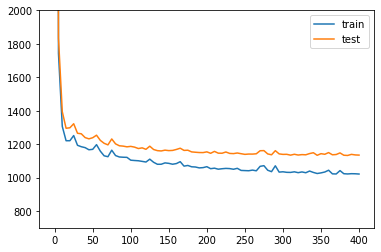

In [11]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 400, (len(elbo_train_set)))
plt.plot(x, elbo_train_set, label="train")
plt.plot(x, elbo_test_set, label="test")
plt.ylim(700, 2000)
plt.legend()

## Obtaining the posterior object and sample latent space as well as imputation from it

The posterior object contains a model and a gene_dataset, as well as additional arguments that for Pytorch's `DataLoader`. It also comes with many methods or utilities querying the model, such as differential expression, imputation and differential analyisis.


To get an ordered output result, we use the `.sequential()` posterior method, which returns another instance of posterior (with shallow copy of all its object references), but where the iteration is in the same ordered as its  indices attribute.

In [12]:
full = trainer.create_posterior()
# Updating the "minibatch" size after training is useful in low memory configurations
full = full.update_batch_size(32)
latent, batch_indices, labels = full.get_latent()
batch_indices = batch_indices.ravel()

Similarly, it is possible to query the imputed values via the `imputation` method of the posterior object. 

Imputation is an ambiguous term and there are two ways to perform imputation in scVI. The first way is to query the **mean of the negative binomial** distribution modeling the counts. This is referred to as `sample_rate` in the codebase and can be reached via the `imputation` method. The second is to query the **normalized mean of the same negative binomial** (please refer to the scVI manuscript). This is referred to as `sample_scale` in the codebase and can be reached via the `get_sample_scale` method. In differential expression for example, we of course rely on the normalized latent variable which is corrected for variations in sequencing depth.

In [13]:
imputed_values = full.imputation()
normalized_values = full.get_sample_scale()
gene_dataset.layers["scVI_normalized"] = normalized_values

The posterior object provides an easy way to save an experiment that includes not only the trained model, but also the associated data with the `save_posterior` and `load_posterior` tools.



### Saving and loading results

In [14]:
# saving step (after training!)
save_dir = os.path.join(save_path, "full_posterior")
if not os.path.exists(save_dir):
    full.save_posterior(save_dir)

In [15]:
# loading step (in a new session)
# retrieved_model = scvi.models.VAE(ss["n_genes"])  # uninitialized model
# save_dir = os.path.join(save_path, "full_posterior")

# retrieved_full = scvi.inference.load_posterior(
#     dir_path=save_dir,
#     model=retrieved_model,
#     use_cuda=use_cuda,
# )

## Visualizing the latent space with scanpy

scanpy is a handy and powerful python library for visualization and downstream analysis of single-cell RNA sequencing data. We show here how to feed the latent space of scVI into a scanpy object and visualize it using UMAP as implemented in scanpy. More on how scVI can be used with scanpy on [this notebook](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/scanpy_pbmc3k.ipynb). **Note to advanced users:** The code `get_latent()` returns only the mean of the posterior distribution for the latent space. However, we recover a full distribution with our inference framework. Let us keep in mind that the latent space visualized here is a practical summary of the data only. Uncertainty is needed for other downstream analyses such as differential expression. 

In [16]:
import scanpy as sc
import anndata

In [17]:
gene_dataset.obsm["X_scVI"] = latent
sc.pp.neighbors(gene_dataset, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(gene_dataset, min_dist=0.3)

... storing 'precise_labels' as categorical
... storing 'cell_type' as categorical


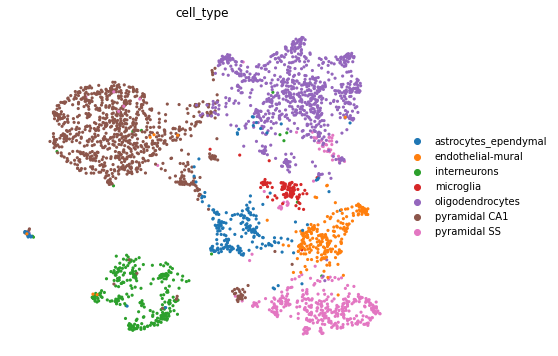

In [18]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(gene_dataset, color=["cell_type"], ax=ax, show=show_plot, frameon=False)

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression). We discuss this in the scanpy tutorial.

## Differential Expression
From the trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of differential expression is measured by $\text{logit}\frac{p}{(1-p)}$ where __p__ is the probability of a cell from population A having a higher expression than a cell from population B. We can form the null distribution of the DE values by sampling pairs randomly from the combined population.

The following example is implemented for the cortext dataset, vary __cell_types__ and __genes_of_interest__ for other datasets. 

**1. Set population A and population B for comparison**

In [19]:
gene_dataset.obs.cell_type.astype("category").cat.categories

Index(['astrocytes_ependymal', 'endothelial-mural', 'interneurons',
       'microglia', 'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'],
      dtype='object')

In [20]:
cell_types = gene_dataset.obs.cell_type.values

cell_idx1 = cell_types == "oligodendrocytes"
cell_idx2 = cell_types == "pyramidal CA1"

**2. Run DE function**

In [21]:
de_res = full.differential_expression_score(
    cell_idx1, 
    cell_idx2, 
)

**3. Print out the differential expression value**
* bayes_factor: The bayes factor for cell type 1 having a higher expression than cell type 2
* proba_m1: The numerator of the bayes_factor quotient, the probability cell type 1 has higher expression than cell type 2
* proba_m2: The denominator of the bayes_factor quotient, equal to 1 minus proba_m1
* raw_mean*i*: average UMI counts in cell type *i*
* non_zeros_proportion*i*: proportion of non-zero expression in cell type *i*
* raw_normalized_mean*i*: average UMI counts in cell type *i* normalized by cell size
* scale*i*: average scVI imputed gene expression scale in cell type *i* 


In [22]:
de_res.head()

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
Car14,0.9996,0.0004,7.823621,0.001553,0.000075,4.192683,0.075612,0.845122,0.040469,3.361164,0.061306
Tmem88b,0.9976,0.0024,6.029880,0.003887,0.000166,11.214634,0.244941,0.981707,0.080937,8.175461,0.183332
Pllp,0.9972,0.0028,5.875328,0.002497,0.000188,7.687805,0.160809,0.937805,0.063898,5.378536,0.123302
Cd82,0.9968,0.0032,5.741396,0.001150,0.000089,3.425610,0.089457,0.819512,0.051118,2.579099,0.070969
Gjc2,0.9968,0.0032,5.741396,0.001159,0.000070,3.174390,0.078807,0.760976,0.039404,2.216812,0.055327


**9. Visualize top 10 most expressed genes per cell types**

In [23]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=cell_types.codes, min_cells=1)

markers = {}
for x, i in zip(per_cluster_de, cluster_id):
    y = x.copy()
    # significance threshold
    y = y[y.bayes_factor > 3]
    # lowly expressed threshold
    y = y[y.non_zeros_proportion1 > 0.1]
    # LFC on scVI normalized data
    y["lfc"] = np.log2(y["scale1"]) - np.log2(y["scale2"])
    # sort by LFC
    y.sort_values(by="lfc", ascending=False, inplace=True)
    # take top 5 markers
    markers[cell_types.categories[i]] = y[:5].index.to_numpy()


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


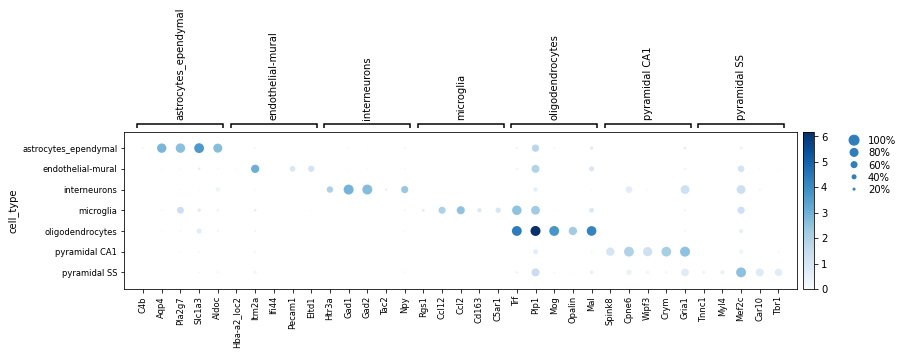

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[12.25, 0, 0.2, 0.5, 0.25])

In [24]:
sc.pl.dotplot(gene_dataset, markers, groupby='cell_type', dendrogram=False, color_map="Blues")

## Correction for batch effects

We now load the RETINA dataset that is described in Shekhar et al. (2016) for an example of batch-effect correction. For more extensive utilization, we encourage the users to visit the [harmonization](https://nbviewer.jupyter.org/github/YosefLab/scVI/blob/master/tests/notebooks/harmonization.ipynb) as well as the [annotation](https://nbviewer.jupyter.org/github/YosefLab/scVI/blob/master/tests/notebooks/annotation.ipynb) notebook which explain in depth how to deal with several datasets (in an unsupervised or semi-supervised fashion). 

* Shekhar, Karthik, et al. "Comprehensive classification of retinal bipolar neurons by single-cell transcriptomics." Cell 166.5 (2016): 1308-1323.

In [26]:
retina_dataset = scvi.dataset.retina(save_path=save_path, run_setup_anndata = False)

[2020-07-21 21:31:24,775] INFO - scvi.dataset._utils | File /data/retina.loom already downloaded


In [27]:
retina_dataset

AnnData object with n_obs × n_vars = 19829 × 13166
    obs: 'labels', 'batch'
    uns: 'CreationDate', 'LOOM_SPEC_VERSION', 'last_modified'

In [28]:
# Notice that the dataset has two batches (labeled as 0 and 1)
retina_dataset.obs.batch[:10]

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
5    0.0
6    1.0
7    1.0
8    0.0
9    0.0
Name: batch, dtype: category
Categories (2, float64): [0.0, 1.0]

In [29]:
scvi.dataset.highly_variable_genes_seurat_v3(retina_dataset, n_top_genes=4000, subset=True)

[2020-07-21 21:31:51,365] INFO - scvi.dataset._preprocessing | added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [30]:
scvi.dataset.setup_anndata(retina_dataset, batch_key="batch")

[2020-07-21 21:31:54,517] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-21 21:31:54,518] INFO - scvi.dataset._anndata | Using batches from adata.obs["batch"]
[2020-07-21 21:31:54,521] INFO - scvi.dataset._anndata | No label_key inputted, assuming all cells have same label
[2020-07-21 21:31:54,526] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-21 21:31:54,660] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 19829 cells, 4000 genes, and 2 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


In [31]:
n_epochs = 200
lr = 1e-3
use_batches = True
use_cuda = True

ss = retina_dataset.uns["scvi_summary_stats"]

# Train the model and output model likelihood every 10 epochs
# if n_batch = 0 then batch correction is not performed
# this is controlled by the use_batches boolean variable
vae = scvi.models.VAE(ss["n_genes"], n_batch=ss["n_batch"] * use_batches)
trainer = scvi.inference.UnsupervisedTrainer(
    vae, 
    retina_dataset, 
    train_size=0.9 if not test_mode else 0.5, 
    use_cuda=use_cuda,
    frequency=10,
)
trainer.train(n_epochs=n_epochs, lr=lr)

[2020-07-21 21:32:04,155] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-07-21 21:32:04,156] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████| 200/200 [07:50<00:00,  2.35s/it]
[2020-07-21 21:39:54,798] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


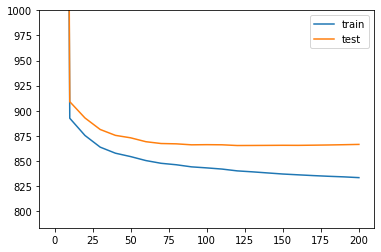

In [32]:
# Plotting the likelihood change across the 400 epochs of training: 
# blue for training error and orange for testing error. 

elbo_train = trainer.history["elbo_train_set"]
elbo_test = trainer.history["elbo_test_set"]
x = np.linspace(0, 200, (len(elbo_train)))
plt.plot(x, elbo_train, label="train")
plt.plot(x, elbo_test, label="test")
plt.ylim(min(elbo_train)-50, 1000)
plt.legend()

**Computing batch mixing**

This is a quantitative measure of how well cells mix in the latent space, and is precisely the information entropy of the batch annotations of cells in a given cell's neighborhood, averaged over the dataset.

In [33]:
full = trainer.create_posterior()
print("Entropy of batch mixing :", full.entropy_batch_mixing())

Entropy of batch mixing : 0.6278220409154036


**Visualizing the mixing**

In [34]:
latent, batch_indices, labels = full.get_latent()

In [35]:
retina_dataset.obsm["X_scVI"] = latent
sc.pp.neighbors(retina_dataset, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(retina_dataset)

... storing 'labels' as categorical


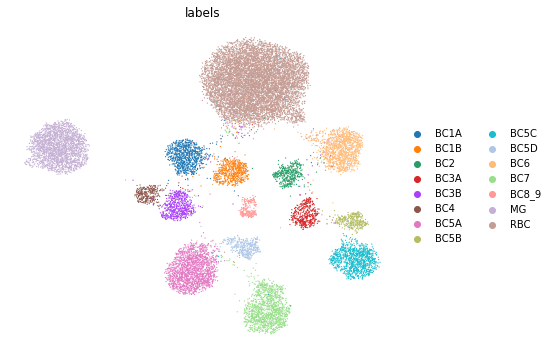

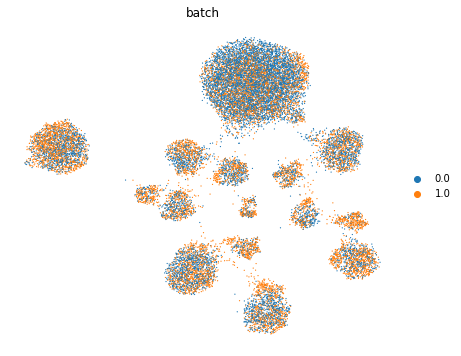

In [36]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(retina_dataset, color=["labels"], ax=ax, show=show_plot, frameon=False)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(retina_dataset, color=["batch"], ax=ax, show=show_plot, frameon=False)

## Logging information

Verbosity varies in the following way:
* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.set_verbosity(level)` to set the verbosity of the scvi package.
Note that `level` corresponds to the logging levels of the standard python `logging` module. By default, that level is set to `INFO` (=20).
As a reminder the logging levels are:
<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>